### Import block

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant

from sklearn.utils import class_weight
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from math import log10, sqrt

%matplotlib inline

In [2]:
# Check for available GPU.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Function definitions

In [3]:
# Loader functions
# Inspiration: https://towardsdatascience.com/writing-custom-keras-generators-fe815d992c5a

def get_input(path):
    # Load array.
    t_input = np.load(path)
    
    # Pad to even number of pixels
    #t_input = np.pad(t_input, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    #t_input = tf.expand_dims(t_input, axis = -1)
    
    # Put channel dim at the end.
    t_input = np.moveaxis(t_input, 1, -1)
    
    return t_input

def get_output(path):
    # Load array.
    t_output = np.load(path)
    
    # Pad to even number of pixels
    #t_output = np.pad(t_output, [(0,0),(0,1),(0,1)])
    # Resize to include a channel dimension.
    #t_output = tf.expand_dims(t_output, axis = -1)
    
    # Put channel dim at the end.
    t_output = np.moveaxis(t_output, 1, -1)
    return t_output

def data_generator(samples, batch_size = 64):
    
    while True:
        # Select files (paths/indices) for the batch
        batch_samples  = np.random.choice(a = samples.index, 
                                      size = batch_size)
        batch_input  = []
        batch_output = [] 

        # Read in each input, perform preprocessing and get labels
        for sample in batch_samples:
          input = get_input(samples.loc[sample].features)
          output = get_output(samples.loc[sample].labels)

          batch_input += [input]
          batch_output += [output]
        # Return a tuple of (input, output) to feed the network
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)
        
        yield(batch_x, batch_y)


In [4]:
### Source: https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
# Modified to 0-1 scale instead of 0-100
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 1
    max_pixel = 1
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr/100

### Load data

In [5]:
# Get data from one chip
m = pd.read_csv('Sample_CLSTM_Dataset/train/meta.csv')
sample_input = np.load('Sample_CLSTM_Dataset/train/features/119179.npy')

# Pad to even number of pixels
#a = np.pad(sample_input, [(0,0),(0,1),(0,1)])
# Resize to include a channel dimension.
#a = tf.expand_dims(a, axis = -1)
# Resize to include a batch dimension.
#a = tf.expand_dims(a, axis = 0)


# Move channel axis to the end
a = np.moveaxis(sample_input, 1, -1)

# Resize to include a batch dimension.
a = tf.expand_dims(a, axis = 0)

# Display shape for verification.
a.shape

TensorShape([1, 10, 32, 32, 2])

### Model assembly

In [6]:
# Inspired by: https://keras.io/examples/vision/conv_lstm/?fbclid=IwAR1QSJmF0bcz5pklHDHwl4mUi8inzHN4m8Zk6OpvVJizqDDv2-MKMq3LlJ8

inputs = layers.Input(shape=((10,32,32,2)))
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding='same',
    return_sequences=True,
    activation='relu',
    recurrent_dropout = 0.1
)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    activation='relu',
    recurrent_dropout = 0.1
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding='same',
    return_sequences=False,
    activation='relu',
    recurrent_dropout = 0.1
)(tf.expand_dims(x, axis = 1))
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(1, 1),
    padding='same',
    return_sequences=False,
    activation='relu',
    recurrent_dropout = 0.1
)(tf.expand_dims(x, axis = 1))
outputs = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'
)(tf.expand_dims(x, axis = 1))

In [7]:
forecast_model = tf.keras.Model(inputs, outputs, name="Conv_LSTM")

In [8]:
# Verify output shape.
forecast_model.predict(a).shape

1/1 [==============================] - 2s 2s/step


(1, 1, 32, 32, 1)

In [9]:
# Display model details.
forecast_model.summary()

Model: "Conv_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 32, 32, 2)]   0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 32, 32, 128)   1664512   
                                                                 
 batch_normalization (BatchN  (None, 10, 32, 32, 128)  512       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 32, 32, 128)       1180160   
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 1, 32, 32, 128)   0 

In [10]:
# Compile model.
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
forecast_model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])

In [11]:
# Data loaders.
batch_size = 64
meta_t = pd.read_csv('Sample_CLSTM_Dataset/train/meta.csv')
meta_v = pd.read_csv('Sample_CLSTM_Dataset/val/meta.csv')
#t_gen = data_generator(meta_t, batch_size = batch_size)
#v_gen = data_generator(meta_v, batch_size = batch_size)

In [12]:
# Trying new approach to build dataset.
x_train, y_train, x_val, y_val = [],[],[],[]

# Iterate over dataset.
for x in range(0,len(meta_t)):
    x_train.append(np.load(meta_t.iloc[x].features))
    y_train.append(np.load(meta_t.iloc[x].labels))
for x in range(0,len(meta_v)):
    x_val.append(np.load(meta_v.iloc[x].features))
    y_val.append(np.load(meta_v.iloc[x].labels))
    
# Stack layers.
x_train = np.stack(x_train)
y_train = np.stack(y_train)
x_val = np.stack(x_val)
y_val = np.stack(y_val)

# Convert values > 1 to 1.
x_train = np.minimum(x_train,1)
y_train = np.minimum(y_train,1)
x_val = np.minimum(x_val,1)
y_val = np.minimum(y_val,1)

# Move channel dims to last.
x_train = np.moveaxis(x_train, 2, -1)
y_train = tf.expand_dims(y_train, axis = -1).numpy()
x_val = np.moveaxis(x_val, 2, -1)
y_val = tf.expand_dims(y_val, axis = -1).numpy()

In [13]:
# Experiment: modify output to single frame.
y_train = y_train[:,:1]
y_val = y_val[:,:1]

In [14]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((9894, 10, 32, 32, 2),
 (9894, 1, 32, 32, 1),
 (1902, 10, 32, 32, 2),
 (1902, 1, 32, 32, 1))

In [15]:
# Solution for problem with class_weights not working with 3D outputs in tensorflow.
# From: https://github.com/keras-team/keras/issues/3653
def generate_sample_weights(training_data, class_weights): 
    #replaces values for up to 3 classes with the values from class_weights#
    sample_weights = [np.where(y==0,class_weights[0],
                        np.where(y==1,class_weights[1],
                        y)) for y in training_data]
    return np.asarray(sample_weights)

In [16]:
# Get class weights for weighted binary cross entropy loss.
weights = class_weight.compute_class_weight('balanced',
                                            [0,1],
                                            y_train.flatten())
# Examine weights.
weights

C:\Users\covad\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0, 1], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([ 0.50664783, 38.10623077])

In [17]:
calculated_sample_weights = generate_sample_weights(y_train, weights)

In [18]:
# Move numpy objects to tensors.
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
calculated_sample_weights = tf.convert_to_tensor(calculated_sample_weights)

In [19]:
# Validate weight matrix shape.
calculated_sample_weights.shape == y_train.shape

True

In [20]:
# Params
batch_size = 8

# Adding callbacks.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=2)

# Train model.
forecast_model.fit(x_train,
                   y_train,
                   epochs = 100, 
                   verbose = 1, 
                   batch_size = batch_size,
                   validation_data = (x_val, y_val),
                   callbacks = [early_stopping, reduce_lr],
                   sample_weight = calculated_sample_weights
                  )

Epoch 1/100
1237/1237 [==============================] - 274s 216ms/step - loss: 0.4685 - accuracy: 0.8219 - val_loss: 0.4114 - val_accuracy: 0.8634 - lr: 1.0000e-04
Epoch 2/100
1237/1237 [==============================] - 267s 215ms/step - loss: 0.4227 - accuracy: 0.8343 - val_loss: 0.3875 - val_accuracy: 0.8629 - lr: 1.0000e-04
Epoch 3/100
1237/1237 [==============================] - 266s 215ms/step - loss: 0.4110 - accuracy: 0.8374 - val_loss: 0.4142 - val_accuracy: 0.8455 - lr: 1.0000e-04
Epoch 4/100
1237/1237 [==============================] - 266s 215ms/step - loss: 0.4013 - accuracy: 0.8419 - val_loss: 0.3459 - val_accuracy: 0.8820 - lr: 1.0000e-04
Epoch 5/100
1237/1237 [==============================] - 266s 215ms/step - loss: 0.3882 - accuracy: 0.8455 - val_loss: 0.3571 - val_accuracy: 0.8630 - lr: 1.0000e-04
Epoch 6/100
1237/1237 [==============================] - 266s 215ms/step - loss: 0.3766 - accuracy: 0.8484 - val_loss: 0.3356 - val_accuracy: 0.8764 - lr: 1.0000e-04
Epoc

In [21]:
# Save trained model.
forecast_model.save('Models/F02')

INFO:tensorflow:Assets written to: Models/F02\assets


INFO:tensorflow:Assets written to: Models/F02\assets


In [20]:
forecast_model = tf.keras.models.load_model('Models/D05')

### Examing single-frame predictions

In [21]:
# Select a random example from the validation dataset.
example = np.random.choice(range(len(x_val)), size=1)[0]

# Pick the first/last ten frames from the example.
feature_frames = x_val[example, ...]
label_frames = y_val[example, ...]
pred_frames = []

# Predict a new set of 10 frames.
# Extract the model's prediction and post-process it.
new_prediction = forecast_model.predict(np.expand_dims(feature_frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
pred_frames.append(predicted_frame)
    

# Extend the set of prediction frames.
pred_frames = np.concatenate(pred_frames)

1/1 [==============================] - 0s 471ms/step


In [22]:
# Shape verification.
label_frames.shape == pred_frames.shape

True

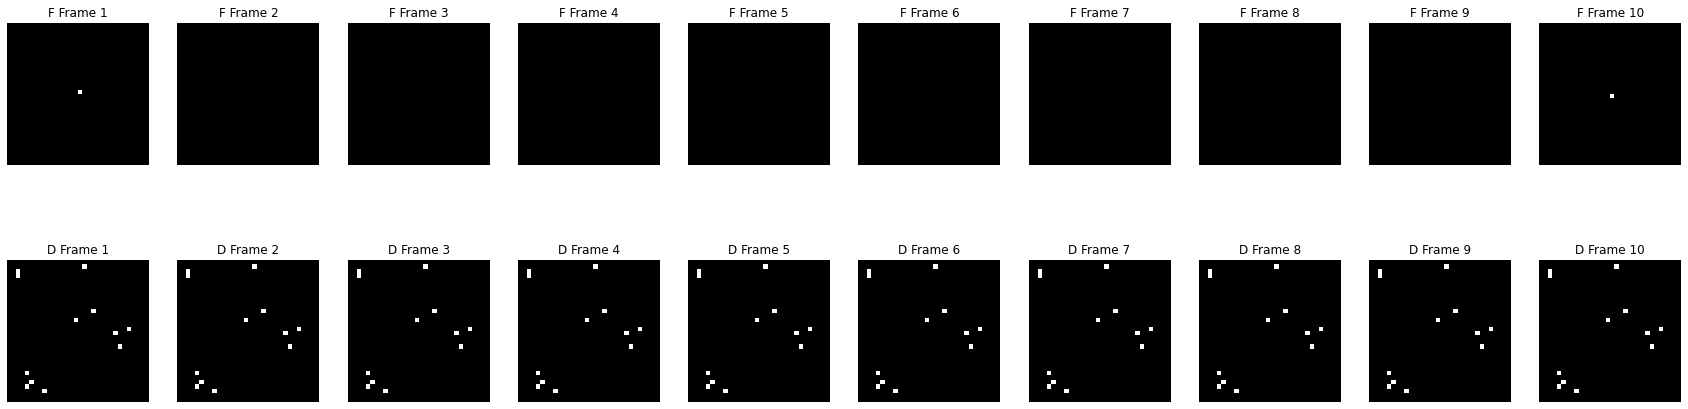

In [23]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

# Plot the fire frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(feature_frames[idx][:,:,:1]), cmap="gray")
    ax.set_title(f"F Frame {idx + 1}")
    ax.axis("off")

# Plot the deforestation frames.
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(feature_frames[idx][:,:,1:2]), cmap="gray")
    ax.set_title(f"D Frame {idx + 1}")
    ax.axis("off")
    
# Display the figure.
plt.show()

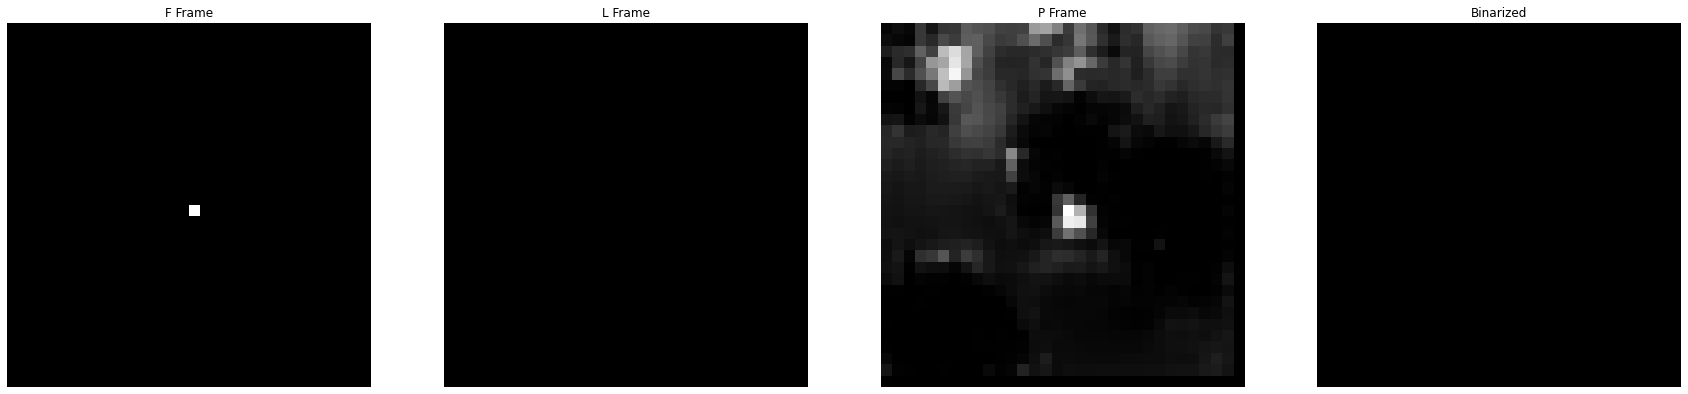

In [24]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(1, 4, figsize=(30, 8))

# Plot the last feature frame.
axes[0].imshow(np.squeeze(feature_frames[9][:,:,:1]), cmap="gray")
axes[0].set_title(f"F Frame")
axes[0].axis("off")

# Plot the label frame.
axes[1].imshow(np.squeeze(label_frames[0]), cmap="gray")
axes[1].set_title(f"L Frame")
axes[1].axis("off")
    
# Plot the predicted frame.
axes[2].imshow(np.squeeze(pred_frames[0]), cmap="gray")
axes[2].set_title(f"P Frame")
axes[2].axis("off")

# Plot binarized prediction.
axes[3].imshow(np.squeeze(np.where(pred_frames > 0.85, 1, 0)), cmap="gray")
axes[3].set_title(f"Binarized")
axes[3].axis("off")

# Display the figure.
plt.show()

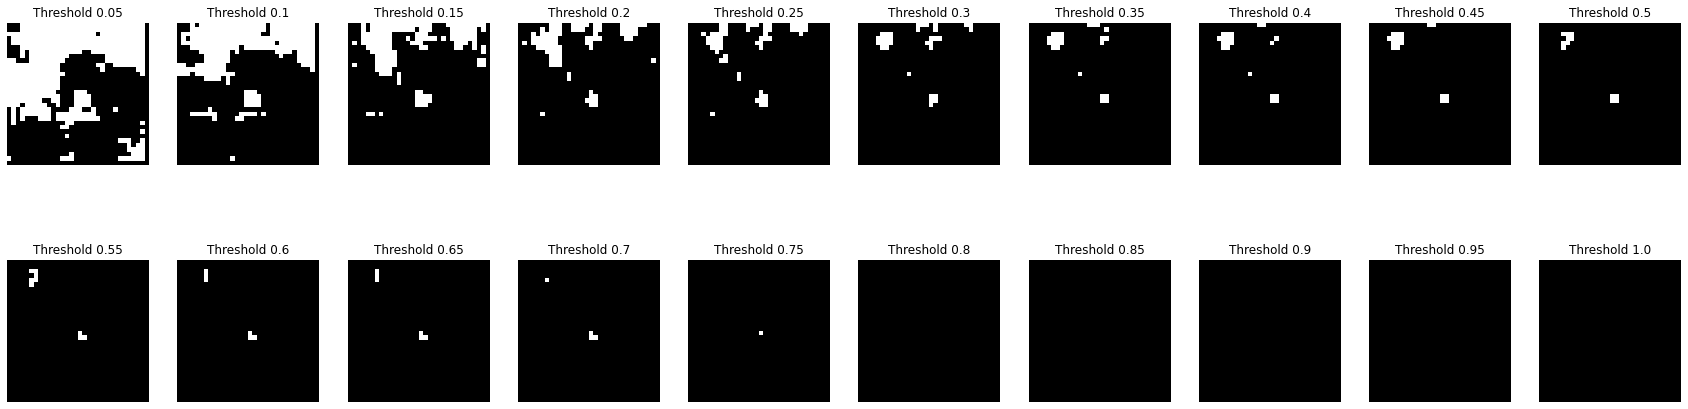

In [25]:
# Construct a figure to show all prediction thresholds.
fig, axes = plt.subplots(2, 10, figsize=(30, 8))

# Plot the frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 1) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 1) * 0.05, 2)}")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(np.where(pred_frames > ((idx + 11) * 0.05), 1, 0)), cmap="gray")
    ax.set_title(f"Threshold {round((idx + 11) * 0.05, 2)}")
    ax.axis("off")
    
# Display the figure.
plt.show()

In [26]:
# Get first sample IoU
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(pred_frames > t, 1, 0), label_frames[0])
    union = np.logical_or(np.where(pred_frames > t, 1, 0), label_frames[0])
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious

C:\Users\covad\AppData\Local\Temp/ipykernel_25392/2665496657.py:7: RuntimeWarning: invalid value encountered in long_scalars
  iou_score = np.sum(intersection) / np.sum(union)


[(0.0, 0.0),
 (0.05, 0.0),
 (0.1, 0.0),
 (0.15, 0.0),
 (0.2, 0.0),
 (0.25, 0.0),
 (0.3, 0.0),
 (0.35, 0.0),
 (0.4, 0.0),
 (0.45, 0.0),
 (0.5, 0.0),
 (0.55, 0.0),
 (0.6, 0.0),
 (0.65, 0.0),
 (0.7, 0.0),
 (0.75, 0.0),
 (0.8, nan),
 (0.85, nan),
 (0.9, nan),
 (0.95, nan),
 (1.0, nan)]

### Get IoU for full prediction set.

In [27]:
# Predict on everything.
all_preds = forecast_model.predict(x_val)

60/60 [==============================] - 10s 160ms/step


In [28]:
# Get IoU.
thresholds = [x/100 for x in range(0,105,5)]
ious = []
for t in thresholds:
    intersection = np.logical_and(np.where(all_preds > t, 1, 0), y_val)
    union = np.logical_or(np.where(all_preds > t, 1, 0), y_val)
    iou_score = np.sum(intersection) / np.sum(union)
    ious.append((t,iou_score))
ious

[(0.0, 0.008262786704784437),
 (0.05, 0.01929093523593379),
 (0.1, 0.026314356236125543),
 (0.15, 0.032674793252290835),
 (0.2, 0.03820780187752172),
 (0.25, 0.04290495288754386),
 (0.3, 0.047473287542628584),
 (0.35, 0.05287554761643398),
 (0.4, 0.06212194531817082),
 (0.45, 0.0684530726638868),
 (0.5, 0.0755263651130826),
 (0.55, 0.07905831562615939),
 (0.6, 0.0830880874476758),
 (0.65, 0.08782642588021307),
 (0.7, 0.09339392595876746),
 (0.75, 0.10003137747097583),
 (0.8, 0.10814913056292366),
 (0.85, 0.11606008926303567),
 (0.9, 0.12508760482370285),
 (0.95, 0.11724012379391953),
 (1.0, 0.0)]

In [29]:
# Get MSE.
mses = [mean_squared_error(all_preds[x], y_val[x].numpy()) for x in range(0,len(all_preds))]
mean_squared_error(all_preds, y_val.numpy())

0.05030678332248258

In [30]:
## Get SSIM if masking is applied.
## Calculation seems to be skewed and giving unreasonably high scores with masking applied.
#thresholds = [x/100 for x in range(0,105,5)]
#masked_ssims = []
#for t in thresholds:
#    t_ssim = [ssim(np.where(all_preds[x][0] > t, 1, 0), y_val[x][0].numpy(), multichannel = True) for x in range(0,len(all_preds))]
#    t_ssim2 = sum(t_ssim) / len(t_ssim)
#    masked_ssims.append((t,t_ssim2))
#masked_ssims

In [31]:
# Get Peak Signal-to-Noise Ratio (PSNR)
psnrs = [PSNR(all_preds[x], y_val[x][0].numpy()) for x in range(0,len(all_preds))]
set_psnr = sum(psnrs) / len(psnrs)
set_psnr

0.15436147725080732

In [33]:
# Get raw mean SSIM
ssims = [ssim(all_preds[x][0], y_val[x][0].numpy(), multichannel = True) for x in range(0,len(all_preds))]
mean_raw_ssim = sum(ssims) / len(ssims)
mean_raw_ssim

C:\Users\covad\anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:107: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ch_result = structural_similarity(im1[..., ch],


0.3729295802378008

In [35]:
# Get DataFrame of all prediction grades.
rows = []
for s in range(0,len(all_preds)): 
    thresholds = [x/100 for x in range(0,105,5)]
    t_ious = []
    for t in thresholds:
        intersection = np.logical_and(np.where(all_preds[s] > t, 1, 0), y_val[s])
        union = np.logical_or(np.where(all_preds[s] > t, 1, 0), y_val[s])
        if np.sum(union) > 0:
            iou_score = np.sum(intersection) / np.sum(union)
        else:
            iou_score = 0
        t_ious.append(iou_score)
    rows.append(t_ious)
iou_df = pd.DataFrame(rows)
iou_df['ssim'] = ssims
iou_df['mse'] = mses
iou_df['psnr'] = psnrs

### Examining Good Predictions

0.9935793148168508

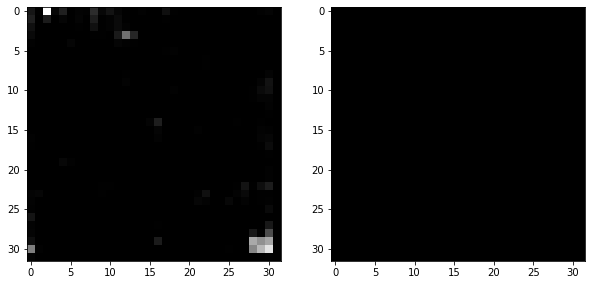

In [36]:
# Examining the best SSIM
x = iou_df.sort_values(by = 'ssim', ascending = False).index[0]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(all_preds[x][0], cmap="gray")
axes[1].imshow(y_val[x][0].numpy(), cmap="gray")
ssims[x]

6.787946633402697e-05

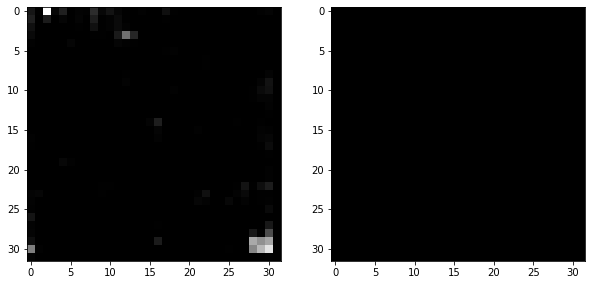

In [37]:
# Examining the best MSE
x = iou_df.sort_values(by = 'mse', ascending = True).index[0]
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(all_preds[x][0], cmap="gray")
axes[1].imshow(y_val[x][0].numpy(), cmap="gray")
mses[x]

In [38]:
iou_df.max()

0       0.131836
1       0.261905
2       0.314286
3       0.333333
4       0.423077
5       0.666667
6       0.666667
7       1.000000
8       1.000000
9       1.000000
10      1.000000
11      1.000000
12      1.000000
13      1.000000
14      1.000000
15      1.000000
16      1.000000
17      1.000000
18      1.000000
19      1.000000
20      0.000000
ssim    0.993579
mse     0.324499
psnr    0.416826
dtype: float64

In [49]:
iou_df[18].sort_values(ascending = False)

1156    1.000000
1608    1.000000
1768    0.833333
731     0.800000
1275    0.666667
          ...   
776     0.000000
774     0.000000
773     0.000000
771     0.000000
1901    0.000000
Name: 18, Length: 1902, dtype: float64

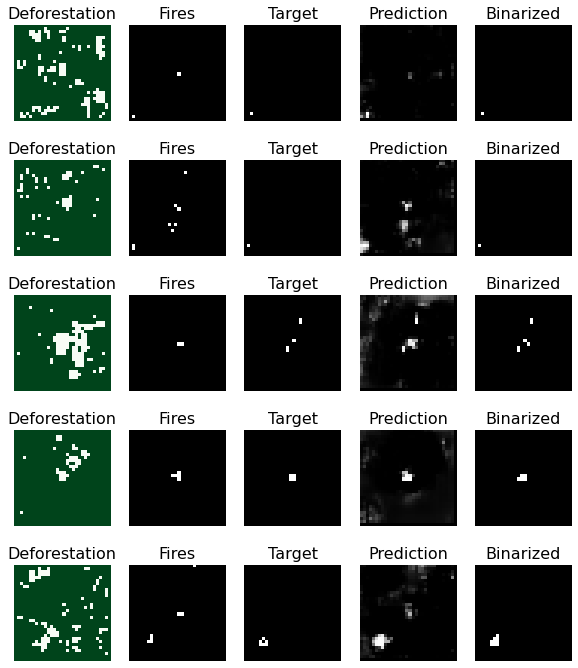

In [78]:
# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(5, 5, figsize=(10, 12))

# List of samples to check:
tgts = list(iou_df[18].sort_values(ascending = False)[:5].index)
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title("Deforestation", fontsize=16)
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title("Fires", fontsize=16)
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title("Target", fontsize=16)
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title("Prediction", fontsize=16)
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.9, 1, 0)), cmap="gray")
    axes[4].set_title("Binarized", fontsize=16)
    axes[4].axis("off")

# Display the figure.
plt.show()

### Examining Pretty Bad Predictions

In [41]:
iou_df[iou_df[19] > 0.02][19].sort_values()

1441    0.020408
332     0.021739
1173    0.022222
1258    0.022727
503     0.022727
          ...   
1275    0.750000
731     0.800000
1482    0.833333
90      1.000000
518     1.000000
Name: 19, Length: 545, dtype: float64

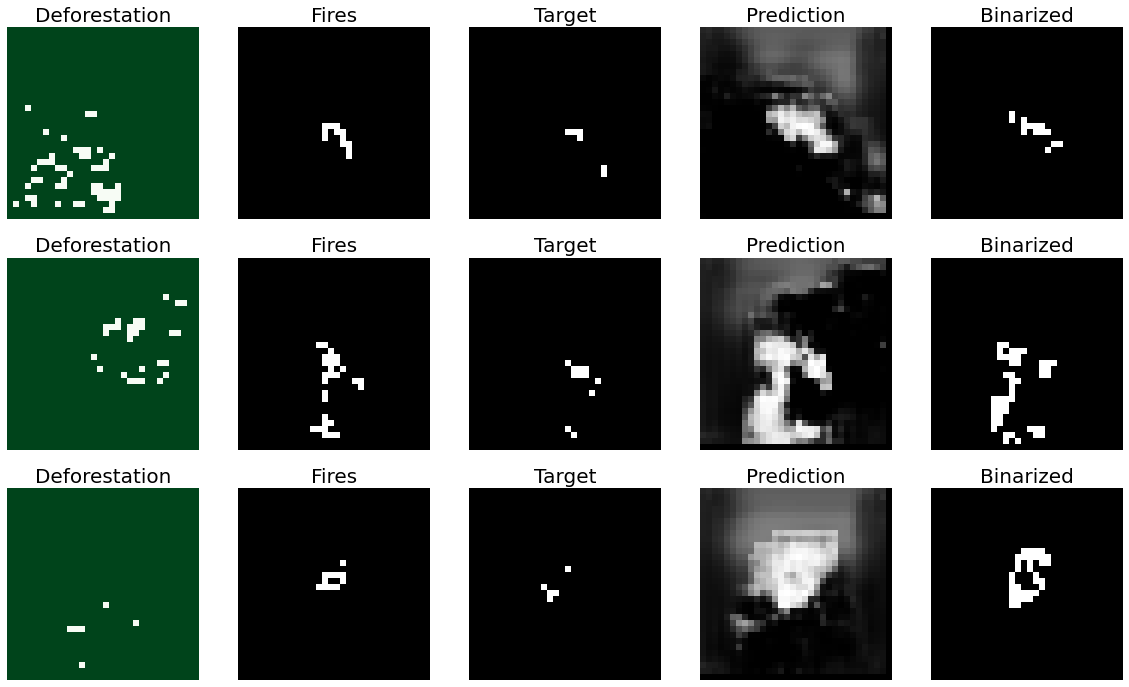

In [75]:
# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(3, 5, figsize=(20, 12))

# List of samples to check:
tgts = list(iou_df[(iou_df[18] > 0.11) & (iou_df[18] < 0.13)][18].sort_values()[:3].index)
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title("Deforestation", fontsize=20)
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title("Fires", fontsize=20)
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title("Target", fontsize=20)
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title("Prediction", fontsize=20)
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.9, 1, 0)), cmap="gray")
    axes[4].set_title("Binarized", fontsize=20)
    axes[4].axis("off")

# Display the figure.
plt.show()

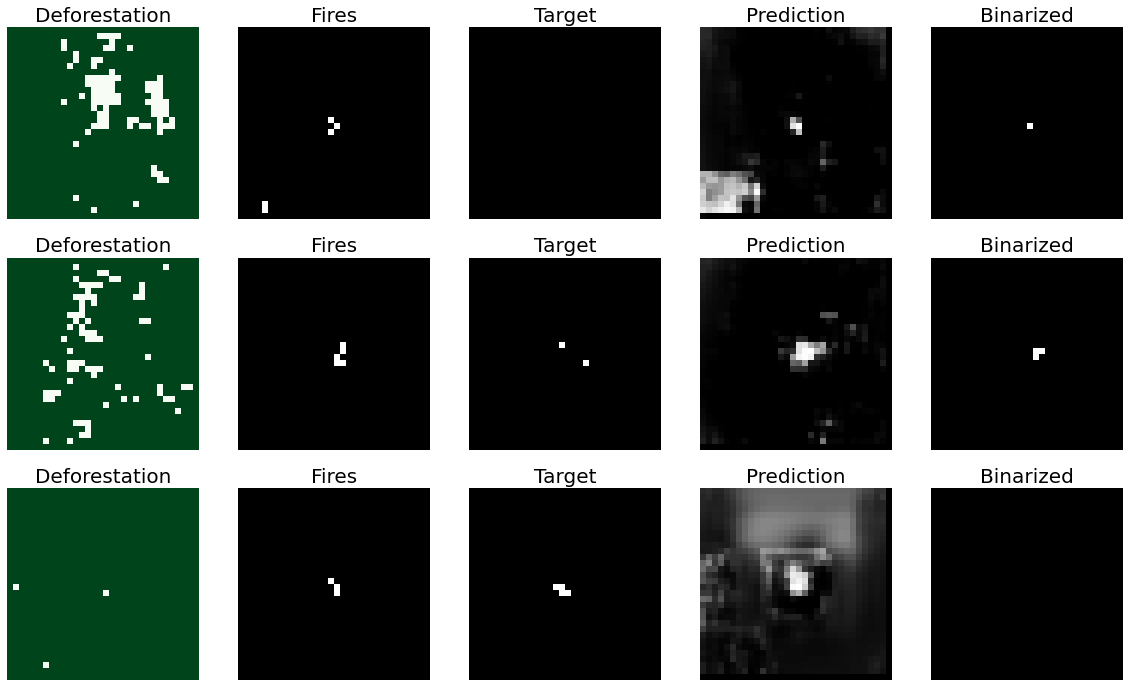

In [85]:
# Construct a figure for the original and new frames.
fig, all_axes = plt.subplots(3, 5, figsize=(20, 12))

# List of samples to check:
tgts = list(iou_df[iou_df[18] < 0.039][18].sort_values()[:3].index)
x = -1

for axes in all_axes:
    x += 1
    
    # Plot deforestaion.
    axes[0].imshow(np.squeeze(x_val[tgts[x]][9][:,:,1:2]), cmap="Greens_r")
    axes[0].set_title("Deforestation", fontsize=20)
    axes[0].axis("off")
    
    # Plot the last feature frame.
    axes[1].imshow(np.squeeze(x_val[tgts[x]][9][:,:,:1]), cmap="gray")
    axes[1].set_title("Fires", fontsize=20)
    axes[1].axis("off")

    # Plot the label frame.
    axes[2].imshow(np.squeeze(y_val[tgts[x]]), cmap="gray")
    axes[2].set_title("Target", fontsize=20)
    axes[2].axis("off")

    # Plot the predicted frame.
    axes[3].imshow(np.squeeze(all_preds[tgts[x]]), cmap="gray")
    axes[3].set_title("Prediction", fontsize=20)
    axes[3].axis("off")

    # Plot binarized prediction.
    axes[4].imshow(np.squeeze(np.where(all_preds[tgts[x]] > 0.9, 1, 0)), cmap="gray")
    axes[4].set_title("Binarized", fontsize=20)
    axes[4].axis("off")

# Display the figure.
plt.show()

In [43]:
# Print all set metrics again for ease of gathering.
print('ssim',mean_raw_ssim)
print('psnr',set_psnr)
print('mse',mean_squared_error(all_preds, y_val.numpy()))
ious

ssim 0.3729295802378008
psnr 0.15436147725080732
mse 0.05030678332248258


[(0.0, 0.008262786704784437),
 (0.05, 0.01929093523593379),
 (0.1, 0.026314356236125543),
 (0.15, 0.032674793252290835),
 (0.2, 0.03820780187752172),
 (0.25, 0.04290495288754386),
 (0.3, 0.047473287542628584),
 (0.35, 0.05287554761643398),
 (0.4, 0.06212194531817082),
 (0.45, 0.0684530726638868),
 (0.5, 0.0755263651130826),
 (0.55, 0.07905831562615939),
 (0.6, 0.0830880874476758),
 (0.65, 0.08782642588021307),
 (0.7, 0.09339392595876746),
 (0.75, 0.10003137747097583),
 (0.8, 0.10814913056292366),
 (0.85, 0.11606008926303567),
 (0.9, 0.12508760482370285),
 (0.95, 0.11724012379391953),
 (1.0, 0.0)]